In [16]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import seaborn as sns
import scipy

# some constants
kB = 1.380649 * 10**-23    # Boltzmann (m^2 kg / s^2 K)
h = 6.62607 * 10**-34      # Planck (m^2 kg / s)
R = 1.9858775 * 10**-3     # universal gas (kcal / mol K)

plt.rcParams['text.usetex'] = True

In [2]:
# read in the experimental data
df = pd.read_csv('csv_data/experimental_data.csv')

df1 = df[df['system'] == 'NaCl (NF270)']
df2 = df[df['system'] == 'NaF (NF270)'].reset_index(drop=True)
df3 = df[df['system'] == 'NaCl (RO)'].reset_index(drop=True)

# make some guesses on parameters
delta = 200 # 200 Angstrom thickness
lam = 2 # 2 Angstrom jumps

In [18]:
def generate_bootstrapped_results(df, n_bootstraps=5000):
    '''Generate bootstrap distributions for the data points and calculate OLS results for each distribution'''

    T = df['T (K)']
    P_experiment = df['ave B (m/sec)']
    P_std = df['SD B']

    # prepare the linear regression inputs
    X = sm.add_constant(1/T)

    # generate bootstrapped data sets
    boot = np.zeros((n_bootstraps, P_experiment.shape[0]))
    for b in range(n_bootstraps):
        for p, perm in enumerate(P_experiment):
            s = P_std[p]
            # perm_distribution = np.random.default_rng().normal(loc=perm, scale=P_std[p])
            perm_distribution = scipy.stats.truncnorm((0-perm)/s, (10**6-perm)/s, loc=perm, scale=s)
            boot[b, p] = perm_distribution.rvs(1)


    # fit each bootstrapped data set to the linear model
    boot_results = np.zeros((n_bootstraps, 2))
    for b,b_data in enumerate(boot):
        ols = sm.OLS(np.log(b_data/T), X)
        res = ols.fit()
        intercept,slope = res.params
        boot_results[b,:] = [intercept, slope]

    return boot_results

### Parametric Bootstrap for the NaCl, NF270 errors, testing different OLS fits

$\ln{P} = \ln{A} - \frac{E_a}{RT}$

So, the slope $m = -\frac{E_a}{R}$ and the intercept $b = \ln{A}$

Or, in terms of the TST model: $\ln{P} = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B T}{h} \right)} + \frac{\Delta S_{eff}}{R} - \frac{\Delta H_{eff}}{RT}$

So, the slope $m = - \frac{\Delta H_{eff}}{R}$ and the intercept $b = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B T}{h} \right)} + \frac{\Delta S_{eff}}{R}$

But, the intercept still has a temperature dependence...

Effective enthalpy from 5000 bootstraps: 4.0 +\- 1.3 kcal/mol
95% confidence interval for effective enthalpy from 5000: (1.4 kcal/mol - 6.4 kcal/mol)

Effective entropic terms from 5000 bootstraps: -0.007 +\- 0.004 kcal/mol/K
95% confidence interval for effective entropic terms from 5000: (-0.016 kcal/mol/K - 0.001 kcal/mol/K)

Effective entropy by removing other term: -0.058 +/- 0.004 kcal/mol/K
95% confidence interval for effective entropy: (-0.067 kcal/mol/K - -0.050 kcal/mol/K)

-TdS: 17.2 +/- 1.3 kcal/mol/K
95% confidence interval for -TdS: (14.857 kcal/mol/K - 19.978 kcal/mol/K)


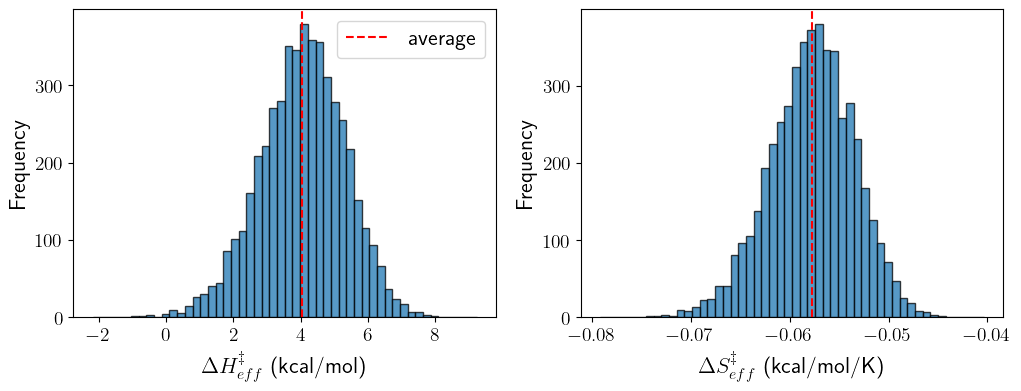

In [4]:
# perform a parametric bootstrap on the experimental data
n_bootstraps = 5000
T = df1['T (K)']
P_experiment = df1['ave B (m/sec)']
P_std = df1['SD B']

# prepare the linear regression inputs
X = sm.add_constant(1/T)

# generate bootstrapped data sets
boot = np.zeros((n_bootstraps, P_experiment.shape[0]))
for b in range(n_bootstraps):
    for p, perm in enumerate(P_experiment):
        perm_distribution = np.random.default_rng().normal(loc=perm, scale=P_std[p])
        boot[b, p] = perm_distribution


# fit each bootstrapped data set to the linear model
boot_results1= np.zeros((n_bootstraps, 2))
for b,b_data in enumerate(boot):
    ols = sm.OLS(np.log(b_data), X) # ln(P) vs 1/T
    res = ols.fit()
    intercept,slope = res.params
    boot_results1[b,:] = [intercept, slope]

dH = boot_results1[:,1]*(-R)
dS_terms = boot_results1[:,0]*R
dS = dS_terms - R*np.log(lam**2/delta * kB*T.mean()/h)

print(f'Effective enthalpy from {n_bootstraps} bootstraps: {dH.mean():.1f} +\- {dH.std():.1f} kcal/mol')
print(f'95% confidence interval for effective enthalpy from {n_bootstraps}: ({np.percentile(dH, 2.5):.1f} kcal/mol - {np.percentile(dH,97.5):.1f} kcal/mol)')

print(f'\nEffective entropic terms from {n_bootstraps} bootstraps: {dS_terms.mean():.3f} +\- {dS_terms.std():.3f} kcal/mol/K')
print(f'95% confidence interval for effective entropic terms from {n_bootstraps}: ({np.percentile(dS_terms, 2.5):.3f} kcal/mol/K - {np.percentile(dS_terms,97.5):.3f} kcal/mol/K)')

print(f'\nEffective entropy by removing other term: {dS.mean():.3f} +/- {dS.std():.3f} kcal/mol/K')
print(f'95% confidence interval for effective entropy: ({np.percentile(dS, 2.5):.3f} kcal/mol/K - {np.percentile(dS,97.5):.3f} kcal/mol/K)')

print(f'\n-TdS: {-T.mean()*dS.mean():.1f} +/- {T.mean()*dS.std():.1f} kcal/mol/K')
print(f'95% confidence interval for -TdS: ({np.percentile(-T.mean()*dS, 2.5):.3f} kcal/mol/K - {np.percentile(-T.mean()*dS,97.5):.3f} kcal/mol/K)')

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(dH, bins=50, alpha=0.75, edgecolor='k')
ax[0].axvline(dH.mean(), ls='dashed', c='r', label='average')
ax[0].set_xlabel('$\Delta H_{eff}^{\ddag}$ (kcal/mol)', fontsize=16)
ax[0].set_ylabel('Frequency', fontsize=16)
ax[0].tick_params('both', labelsize=14)
ax[0].legend(fontsize=16)

ax[1].hist(dS, bins=50, alpha=0.75, edgecolor='k')
ax[1].axvline(dS.mean(), ls='dashed', c='r', label='average')
ax[1].set_xlabel('$\Delta S_{eff}^{\ddag}$ (kcal/mol/K)', fontsize=16)
ax[1].set_ylabel('Frequency', fontsize=16)
ax[1].tick_params('both', labelsize=14)

$\ln{\frac{P}{T}} = \ln{A} - \frac{E_a}{RT}$

So, the slope $m = -\frac{E_a}{R}$ and the intercept $b = \ln{A}$

Or, in terms of the TST model: $\ln{\frac{P}{T}} = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B}{h} \right)} + \frac{\Delta S_{eff}}{R} - \frac{\Delta H_{eff}}{RT}$

So, the slope $m = - \frac{\Delta H_{eff}}{R}$ and the intercept $b = \ln{\left( \frac{\lambda^2}{\delta} \frac{k_B}{h} \right)} + \frac{\Delta S_{eff}}{R}$

Effective enthalpy from 5000 bootstraps: 3.4 +\- 1.2 kcal/mol
95% confidence interval for effective enthalpy from 5000: (0.9 kcal/mol - 5.7 kcal/mol)

Effective entropic terms from 5000 bootstraps: -0.020 +\- 0.004 kcal/mol/K
95% confidence interval for effective entropic terms from 5000: (-0.029 kcal/mol/K - -0.013 kcal/mol/K)

Effective entropy by removing other term: -0.060 +/- 0.004 kcal/mol/K
95% confidence interval for effective entropy: (-0.068 kcal/mol/K - -0.052 kcal/mol/K)

-TdS: 17.8 +/- 1.3 kcal/mol/K
95% confidence interval for -TdS: (15.533 kcal/mol/K - 20.436 kcal/mol/K)


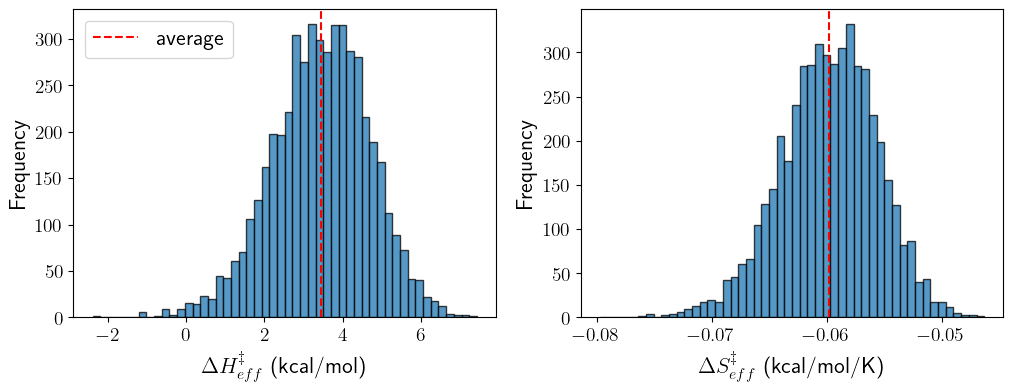

In [5]:
# perform a parametric bootstrap on the experimental data
n_bootstraps = 5000
boot_results2 = generate_bootstrapped_results(df1, n_bootstraps=n_bootstraps) # ln(P/T) vs 1/T

dH = boot_results2[:,1]*(-R)
dS_terms = boot_results2[:,0]*R
dS = dS_terms - R*np.log(lam**2/delta * kB/h)

print(f'Effective enthalpy from {n_bootstraps} bootstraps: {dH.mean():.1f} +\- {dH.std():.1f} kcal/mol')
print(f'95% confidence interval for effective enthalpy from {n_bootstraps}: ({np.percentile(dH, 2.5):.1f} kcal/mol - {np.percentile(dH,97.5):.1f} kcal/mol)')

print(f'\nEffective entropic terms from {n_bootstraps} bootstraps: {dS_terms.mean():.3f} +\- {dS_terms.std():.3f} kcal/mol/K')
print(f'95% confidence interval for effective entropic terms from {n_bootstraps}: ({np.percentile(dS_terms, 2.5):.3f} kcal/mol/K - {np.percentile(dS_terms,97.5):.3f} kcal/mol/K)')

print(f'\nEffective entropy by removing other term: {dS.mean():.3f} +/- {dS.std():.3f} kcal/mol/K')
print(f'95% confidence interval for effective entropy: ({np.percentile(dS, 2.5):.3f} kcal/mol/K - {np.percentile(dS,97.5):.3f} kcal/mol/K)')

print(f'\n-TdS: {-T.mean()*dS.mean():.1f} +/- {T.mean()*dS.std():.1f} kcal/mol/K')
print(f'95% confidence interval for -TdS: ({np.percentile(-T.mean()*dS, 2.5):.3f} kcal/mol/K - {np.percentile(-T.mean()*dS,97.5):.3f} kcal/mol/K)')

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(dH, bins=50, alpha=0.75, edgecolor='k')
ax[0].axvline(dH.mean(), ls='dashed', c='r', label='average')
ax[0].set_xlabel('$\Delta H_{eff}^{\ddag}$ (kcal/mol)', fontsize=16)
ax[0].set_ylabel('Frequency', fontsize=16)
ax[0].tick_params('both', labelsize=14)
ax[0].legend(fontsize=16)

ax[1].hist(dS, bins=50, alpha=0.75, edgecolor='k')
ax[1].axvline(dS.mean(), ls='dashed', c='r', label='average')
ax[1].set_xlabel('$\Delta S_{eff}^{\ddag}$ (kcal/mol/K)', fontsize=16)
ax[1].set_ylabel('Frequency', fontsize=16)
ax[1].tick_params('both', labelsize=14)

$\ln{\left( \frac{P \delta h}{\lambda^2 k_B T} \right)} = \ln{A} - \frac{E_a}{RT}$

So, the slope $m = -\frac{E_a}{R}$ and the intercept $b = \ln{A}$

Or, in terms of the TST model: $\ln{\left( \frac{P \delta h}{\lambda^2 k_B T} \right)} = \frac{\Delta S_{eff}}{R} - \frac{\Delta H_{eff}}{RT}$

So, the slope $m = - \frac{\Delta H_{eff}}{R}$ and the intercept $b = \frac{\Delta S_{eff}}{R}$

Effective enthalpy from 5000 bootstraps: 3.4 +\- 1.2 kcal/mol
95% confidence interval for effective enthalpy from 5000: (0.8 kcal/mol - 5.8 kcal/mol)

Effective entropy from 5000 bootstraps: -0.060 +/- 0.004 kcal/mol/K
95% confidence interval for effective entropy: (-0.069 kcal/mol/K - -0.052 kcal/mol/K)

-TdS: 17.8 +/- 1.3 kcal/mol/K
95% confidence interval for -TdS: (15.510 kcal/mol/K - 20.503 kcal/mol/K)


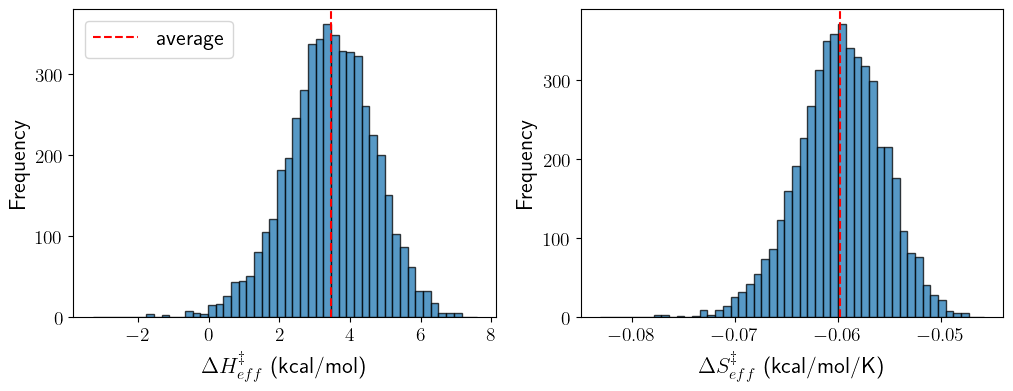

In [6]:
# perform a parametric bootstrap on the experimental data
n_bootstraps = 5000
T = df1['T (K)']
P_experiment = df1['ave B (m/sec)']
P_std = df1['SD B']

# prepare the linear regression inputs
X = sm.add_constant(1/T)

# generate bootstrapped data sets
boot = np.zeros((n_bootstraps, P_experiment.shape[0]))
for b in range(n_bootstraps):
    for p, perm in enumerate(P_experiment):
        perm_distribution = np.random.default_rng().normal(loc=perm, scale=P_std[p])
        boot[b, p] = perm_distribution


# fit each bootstrapped data set to the linear model
boot_results3 = np.zeros((n_bootstraps, 2))
for b,b_data in enumerate(boot):
    ols = sm.OLS(np.log(b_data*delta*h/lam**2/kB/T), X)
    res = ols.fit()
    intercept,slope = res.params
    boot_results3[b,:] = [intercept, slope]

dH = boot_results3[:,1]*(-R)
dS = boot_results3[:,0]*R

print(f'Effective enthalpy from {n_bootstraps} bootstraps: {dH.mean():.1f} +\- {dH.std():.1f} kcal/mol')
print(f'95% confidence interval for effective enthalpy from {n_bootstraps}: ({np.percentile(dH, 2.5):.1f} kcal/mol - {np.percentile(dH,97.5):.1f} kcal/mol)')

print(f'\nEffective entropy from {n_bootstraps} bootstraps: {dS.mean():.3f} +/- {dS.std():.3f} kcal/mol/K')
print(f'95% confidence interval for effective entropy: ({np.percentile(dS, 2.5):.3f} kcal/mol/K - {np.percentile(dS,97.5):.3f} kcal/mol/K)')

print(f'\n-TdS: {-T.mean()*dS.mean():.1f} +/- {T.mean()*dS.std():.1f} kcal/mol/K')
print(f'95% confidence interval for -TdS: ({np.percentile(-T.mean()*dS, 2.5):.3f} kcal/mol/K - {np.percentile(-T.mean()*dS,97.5):.3f} kcal/mol/K)')

fig, ax = plt.subplots(1,2, figsize=(12,4))
ax[0].hist(dH, bins=50, alpha=0.75, edgecolor='k')
ax[0].axvline(dH.mean(), ls='dashed', c='r', label='average')
ax[0].set_xlabel('$\Delta H_{eff}^{\ddag}$ (kcal/mol)', fontsize=16)
ax[0].set_ylabel('Frequency', fontsize=16)
ax[0].tick_params('both', labelsize=14)
ax[0].legend(fontsize=16)

ax[1].hist(dS, bins=50, alpha=0.75, edgecolor='k')
ax[1].axvline(dS.mean(), ls='dashed', c='r', label='average')
ax[1].set_xlabel('$\Delta S_{eff}^{\ddag}$ (kcal/mol/K)', fontsize=16)
ax[1].set_ylabel('Frequency', fontsize=16)
ax[1].tick_params('both', labelsize=14)

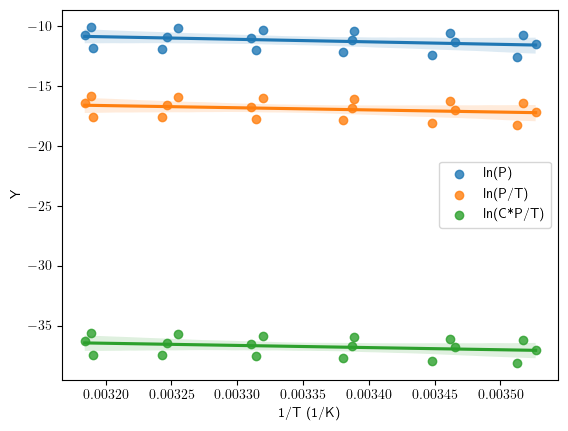

In [7]:
# plot the linear fits
df['1/T (1/K)'] = 1/df['T (K)']
df['ln(P)'] = np.log(df['ave B (m/sec)'])
df['ln(P/T)'] = np.log(df['ave B (m/sec)'] / df['T (K)'])
df['ln(CP/T)'] = np.log(df['ave B (m/sec)']*delta*h/lam**2/kB/df['T (K)'])

fig, ax = plt.subplots(1,1)
sns.regplot(x='1/T (1/K)', y='ln(P)', data=df, ax=ax, label='ln(P)', ci=95)
sns.regplot(x='1/T (1/K)', y='ln(P/T)', data=df, ax=ax, label='ln(P/T)', ci=95)
sns.regplot(x='1/T (1/K)', y='ln(CP/T)', data=df, ax=ax, label='ln(C*P/T)')

plt.ylabel('Y')
plt.legend();

### Replicate the experimental plots in the paper with bootstrapped error

In [30]:
# generate the barrier data with error for plotting
barriers = pd.DataFrame()
barriers['system'] = ['NaCl (water)', 'NaCl (NF270)', 'NaF (NF270)', 'NaCl (RO)']

# perform a parametric bootstrap on the experimental data
barrier_mean = [3.5]
barrier_std = [0.1]
for tmp in [df1,df2,df3]:
    n_bootstraps = 5000
    boot_results = generate_bootstrapped_results(tmp, n_bootstraps=n_bootstraps)
    dH = boot_results[:,1]*(-R)
    barrier_mean.append(dH.mean())
    barrier_std.append(dH.std())

barriers['effective enthalpy'] = barrier_mean
barriers['error'] = barrier_std

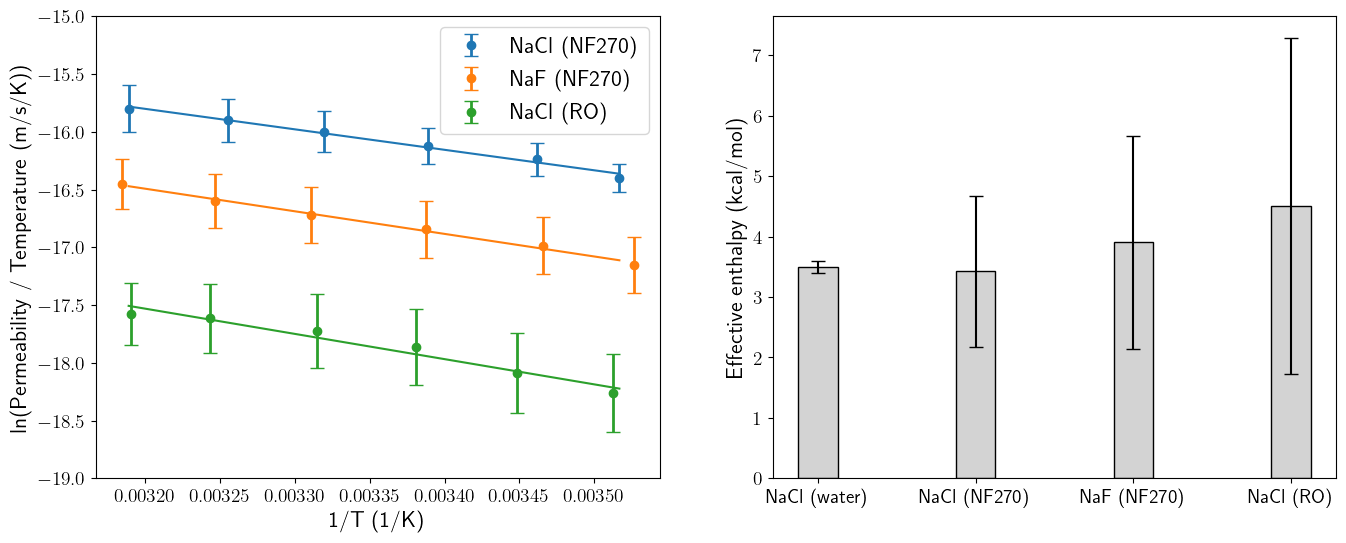

In [32]:
# plot ln(P/T) vs 1/T, which would correspond to the TST model
systems = ['NaCl (NF270)', 'NaF (NF270)', 'NaCl (RO)']
colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, ax = plt.subplots(1,2, figsize=(16,6))

# plot the TST linear regression plots
for sys,c in zip(systems,colors):
    tmp = df[df['system'] == sys]

    # perform linear regression for plotting
    X = sm.add_constant(tmp['1/T (1/K)'])
    ols = sm.OLS(tmp['ln(P/T)'], X)
    res = ols.fit()
    b, m = res.params

    # plot the linear regression and the data points with error
    ax[0].plot(1/T, m/T+b, color=c)
    ax[0].errorbar(tmp['1/T (1/K)'], tmp['ln(P/T)'], yerr=np.abs(tmp['SD B'] / tmp['ave B (m/sec)']),
                 marker='o', capsize=5, label=sys, lw=0, elinewidth=2, color=c)

ax[0].set_ylim(-19, -15)
ax[0].set_ylabel('ln(Permeability / Temperature (m/s/K))', fontsize=16)
ax[0].set_xlabel('1/T (1/K)', fontsize=16)
ax[0].tick_params('both', labelsize=14)
ax[0].legend(loc='best', fontsize=16)

# plot the barriers with bootstrapped errors
ax[1].bar(barriers['system'], barriers['effective enthalpy'], yerr=barriers['error'],
          facecolor='lightgray', edgecolor='k', width=0.25, capsize=5)
ax[1].set_ylabel('Effective enthalpy (kcal/mol)', fontsize=16)
ax[1].tick_params('both', labelsize=14)

fig.savefig('figs/experimental_data.png')